In [1]:
from fastai.conv_learner import *
from fastai.dataset import *
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

import ast
import random

torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
PATH = Path("../data/hanged_man")
MASTERCSV = PATH/"tmp/data_master.csv"
CLASSESCSV = PATH/"tmp/classes.csv"
MBB_CSV = PATH/'tmp/mbb.csv'
JPEGS = 'f_train'
LRG_CSV = PATH/"tmp/lrg_bb.csv"

converters = {"annos":ast.literal_eval,"class_id":ast.literal_eval, "class_str":ast.literal_eval, "lrg_bb":ast.literal_eval}

In [4]:
data = pd.read_csv(MASTERCSV, converters=converters)

In [5]:
def get_lrg(b):
    if not b: raise Exception()
    b = [anno[0] for anno in b]
    b = sorted(b, key=lambda x: np.product(np.array(x[-2:]) - np.array(x[:2])), reverse=True)
    return b[0]
# get_lrg(data.annos[0])
data["lrg_bb"] = data.annos.apply(get_lrg)

In [6]:
def l_to_str(row):
    return ' '.join([str(c) for c in row])
data["lrg_bb_str"] = data.lrg_bb.apply(l_to_str)

In [5]:
data.to_csv(MASTERCSV)

In [5]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8,))
#     ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [6]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], classes.query("id==@c"), sz=16)

def draw_idx(i):
    im_a = data.query('id==@i')
    im = open_image(PATH/f'f_train/{data.query("id==@i").fn.values[0]}')
    draw_im(im, im_a)

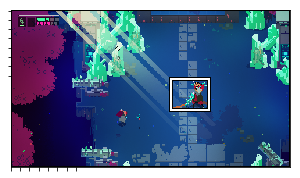

In [7]:
idx = random.choice(range(len(data)))
b = data.lrg_bb[idx]
b = bb_hw(b)
ax = show_img(open_image(PATH/JPEGS/data.fn[idx]), figsize=(5,10))
draw_rect(ax, b)
# draw_text(ax, b[:2], classes[c], sz=16)

In [8]:
df = data.loc[:,["fn","lrg_bb_str"]]
df.columns = ["fn", "bbox"]
df.to_csv(LRG_CSV,index=False)

In [33]:
base_model = resnet34
sz=224
bs=12

aug_tfms = [RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
           RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(base_model, sz, aug_tfms=aug_tfms, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, LRG_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)

In [10]:
x,y=next(iter(md.val_dl))

[102.  78.  23.  42.]
[100.  78.  23.  42.]


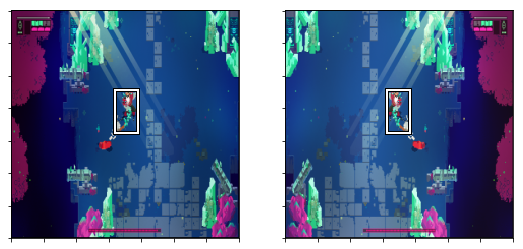

In [11]:
idx = random.choice(range(bs))
fig,axes = plt.subplots(1,2, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [12]:
anc_grid = 7
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range (anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
n_act = k*4

In [13]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv0 = StdConv(256,256)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        
    def forward(self, x):
        return flatten_conv(self.oconv2(x), self.k)
    
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv1 = StdConv(256,256, stride=1)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        return self.out(self.sconv1(self.sconv0(self.drop(F.relu(x)))))

In [63]:
def intersect(box_a, box_b):
    """ Returns the intersection of two boxes """
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): 
    """ Returns the box size"""
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    """ Returns the jaccard distance between two boxes"""
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def get_y(bbox):
    """ ??? """
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep]

def actn_to_bb(actn, anchors):
    """ activations to bounding boxes """
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    """ ?? """
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_bb,bbox,print_it=False):
    bbox = get_y(bbox)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
#     gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.45
    pos_idx = torch.nonzero(pos)[:,0]
#     gt_clas[1-pos] = len(classes)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
#     clas_loss = loss_f(b_c, gt_clas)
    return loc_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_bb,bbox in zip(pred,targ):
        loc_loss = ssd_1_loss(b_bb,bbox,print_it)
        lls += loc_loss
    if print_it: print(f'loc: {lls.data[0]}')
    return lls

In [45]:
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(base_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

# x, y = next(iter(md.trn_dl))
x, y = V(x), V(y)

learn.model.cuda()
batch = learn.model(x)

In [64]:
ssd_loss(batch, y, True)


 0.4645
[torch.cuda.FloatTensor of size 1 (GPU 0)]



RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generated/../THCReduceAll.cuh:339

In [49]:
vals=[]
learn.crit = ssd_loss
lr = 2e-4
lrs = np.array([lr/1000,lr/100,lr])
learn.lr_find()

epoch      trn_loss   val_loss                             
    0      0.738992   0.957484  



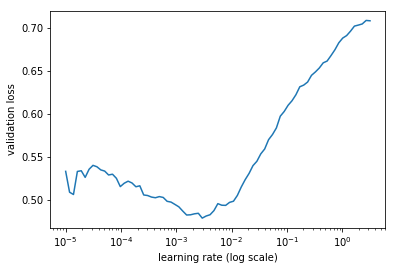

In [50]:
learn.sched.plot(0)

In [53]:
vals.append((lr, learn.fit(lr, 1, cycle_len=10, use_clr=(20,10))))

epoch      trn_loss   val_loss                             
    0      0.255921   0.290408  
    1      0.266137   0.303952                             
    2      0.265246   0.274017                             
    3      0.250633   0.270618                             
    4      0.241969   0.257572                             
    5      0.234567   0.257603                             
    6      0.231445   0.252027                             
    7      0.216631   0.249806                             
    8      0.21542    0.244492                             
    9      0.209274   0.244338                             



epoch      trn_loss   val_loss                             
    0      0.520323   0.971861  



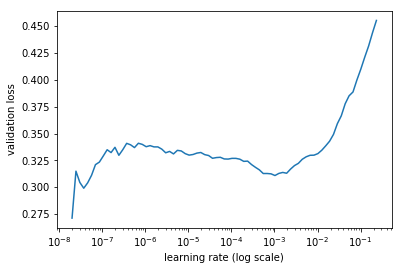

In [54]:
learn.freeze_to(-3)
learn.lr_find(lr/10000,1.)
learn.sched.plot(0)

epoch      trn_loss   val_loss                             
    0      0.518758   0.942421  



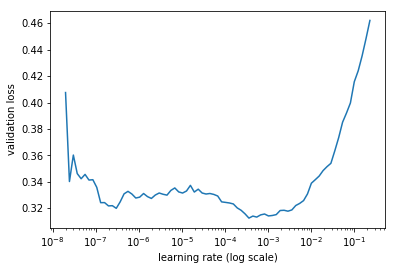

In [55]:
learn.freeze_to(-4)
learn.lr_find(lr/10000,lr)
learn.sched.plot(0)

In [32]:
learn.freeze_to(-2)
# learn.lr_find(lr/1000000,lr/1000)
# learn.sched.plot(0)
learn.fit(9e-8, 1, cycle_len=5, use_clr=(20, 10))

epoch      trn_loss   val_loss                               
    0      0.307332   0.300022  
    1      0.307802   0.300521                               
    2      0.316736   0.299726                               
    3      0.313195   0.299489                               
    4      0.309622   0.301057                               



[array([0.30106])]

epoch      trn_loss   val_loss                               
    0      0.398134   0.690795  



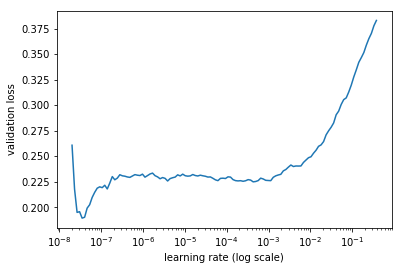

In [52]:
learn.freeze_to(-5)
learn.lr_find(lr/10000,1.)
learn.sched.plot(0)

epoch      trn_loss   val_loss                               
    0      0.436431   0.531083  



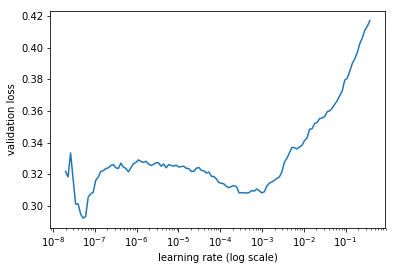

In [28]:
learn.unfreeze()
learn.lr_find(lr/10000,1.)
learn.sched.plot(0)

In [56]:
learn.save("LRG_anc1")

In [57]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
batch

idx=random.choice(range(bs))

bbox = get_y(y[idx])

In [58]:
overlaps = jaccard(bbox.data, anchor_cnr.data)

In [78]:
prior_overlap, prior_idx = overlaps.max(1)
gt_overlap, gt_idx = overlaps.max(0)
gt_overlap[prior_idx] = 1.99
for i,o in enumerate(prior_idx): gt_idx[o] = i + 1


In [80]:
gt_idx


 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.cuda.LongTensor of size 49 (GPU 0)]